# In this notebook, I'll try to apply TRANSFORMER model for a CHATBOT from scratch

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Overview
***
*A chatbot or chatterbot is a software application used to conduct an on-line chat conversation via text or text-to-speech, in lieu of providing direct contact with a live human agent chatbot is a type of software that can help human by automating conversations and interact with them through messaging platforms. here are different approaches and tools that you can use when building chatbots. Depending on the use case you want to address, some technologies are more appropriate than others. Combining artificial intelligence forms such as natural language processing, machine learning, and semantic understanding may be the best option to achieve the desired results.*
***


## How to build a Chatbot for our task?
***
ChatBots are usually Task specific means if there a chatbot which serves only food delivery app have trained on a dataset which
completely different from the dataset on which chatbot which serves online healthcare app. Similary, for this kaggle problem
we have provided with movie dataset which may feel that its not specific to any task, but actually it is specific to how people
will interect generally as these movie dialogues are nothing but daily life conversation between people however, that chatbot
may reply things which sounds too much dramatic and filmy like some dialogue of Tom cruise, shah rukh khan etc.

We can approch this problem by applying Neural network models like encoder-decoder architecture with some attention mechanism.
***

In [2]:
!pip install transformers
import transformers
import numpy as np
import codecs
import tensorflow as tf
import pandas as pd
import ast
import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
# import seaborn as sns
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import re
import warnings
import tensorflow_datasets as tfds
import tensorflow as tf
import joblib
import time
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Progbar
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 27.9 MB/s 
     |████████████████████████████████| 7.6 MB 51.8 MB/s 
     |████████████████████████████████| 182 kB 68.9 MB/s 


## Loading cleaned data that I have preprared while EDA and preprocessing

In [3]:
dialogs = pd.read_csv('/content/dialogs_expanded.csv')
print(dialogs.shape)
dialogs.head()
data = dialogs[['question', 'answer']]




#data = joblib.load('data_cleaned')
data.head()

(139409, 7)


,question,answer
0,"Well, I thought we'd start with pronunciation,...",Not the hacking and gagging and spitting part....
1,Not the hacking and gagging and spitting part....,Okay... then how 'bout we try out some French ...
2,You're asking me out. That's so cute. What's ...,Forget it.
3,"No, no, it's my fault -- we didn't have a prop...",Cameron.
4,"Gosh, if only we could find Kat a boyfriend...",Let me see what I can do.


## Dividing into TWO, train/validation

In [4]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(data, test_size=0.2, random_state=4)

In [5]:
vocab_ans = list(set(" ".join(train['answer'].values).split()))
vocab_ques = list(set(" ".join(train['question'].values).split()))
vocab_size_ans, vocab_size_ques = len(vocab_ans), len(vocab_ques)
print(f"vocab_size_ans, vocab_size_ques:{vocab_size_ans},{ vocab_size_ques}")

vocab_size_ans, vocab_size_ques:69016,69135


## Using tfds SubwordTextEncoder, it will create tokens
#### example Multiplication -> Multi, pli, cat, i, on 
#### Advantages: 
    1. Reduces vocab size => faster learning
    2. Reduces chances of missing word in test data

In [6]:
tokenizer_a = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    train['answer'], target_vocab_size=2**15) 

tokenizer_q = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    train['question'], target_vocab_size=2**15)

In [7]:
print(f"tokenizer_q:{tokenizer_q.vocab_size}")
print(f"tokenizer_a:{tokenizer_a.vocab_size}")

tokenizer_q:23598
tokenizer_a:30402


#### Examples of subword tokenization in action!

In [8]:
sample_string = 'Encoder decoder'

tokenized_string = tokenizer_a.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_a.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

for token in tokenized_string:
    print(str(token) + "---->" + tokenizer_a.decode([token]))

print("="*80)
tokenized_string = tokenizer_q.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_q.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

for token in tokenized_string:
    print(str(token) + "---->" + tokenizer_q.decode([token]))

Tokenized string is [17990, 3488, 1119, 23930, 8104, 627]
The original string: Encoder decoder
17990---->En
3488---->code
1119---->r 
23930---->dec
8104---->od
627---->er
Tokenized string is [16278, 18272, 769, 19843, 23456]
The original string: Encoder decoder
16278---->Enc
18272---->ode
769---->r 
19843---->decode
23456---->r


###### 0-27512 for questions

###### 0-27357 for answers

* **Attaching token number '27513' representing \<start> and '27514' representing \<end> QUESTIONS**
* **Attaching token number '27358' representing \<start> and '27359' representing \<end> ANSWERS**

In [9]:
def encode(ques, ans):
    ques = [tokenizer_q.vocab_size] + tokenizer_q.encode(ques.numpy()) + [tokenizer_q.vocab_size+1]
    ans = [tokenizer_a.vocab_size] + tokenizer_a.encode(ans.numpy()) + [tokenizer_a.vocab_size+1]
    return ques, ans

def tf_encode(ques, ans):
    result_ques, result_ans = tf.py_function(encode, [ques, ans], [tf.int64, tf.int64])
    result_ques.set_shape([None])
    result_ans.set_shape([None])
    return result_ques, result_ans

In [10]:
print(train['question'].values[0],"\n",train['answer'].values[0])
question, answer = tf_encode(train['question'].values[0],train['answer'].values[0])
print(question)
print(answer)

And the fifty's all gone, huh? Who's the ten for? 
 The Websters.
tf.Tensor(
[23598    70     6  1443 23381     5    62   627     1   321    35   336
 23381     5     6   591   272 23405 23599], shape=(19,), dtype=int64)
tf.Tensor([30402    54 25555 30192 30403], shape=(5,), dtype=int64)


### Creating train_dataset/test_dataset object from Dataframe + padding

###### prefetch: If I'm at epoch-20 then prefetch prepares the Batch for epoch-21, so when epoch-21 start, it will make available the batch in no time, basically enhancing speed

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices(dict(train))
train_dataset = train_dataset.map(lambda x:tf_encode(x['question'], x['answer']))
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(20000).padded_batch(64, padded_shapes=([None],[None])) 
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE) 

In [12]:
val_dataset = tf.data.Dataset.from_tensor_slices(dict(validation))
val_dataset = val_dataset.map(lambda x:tf_encode(x['question'], x['answer']))
val_dataset = val_dataset.padded_batch(64, padded_shapes=([None],[None]))

In [13]:
question, answer = next(iter(train_dataset))
question

<tf.Tensor: shape=(64, 34), dtype=int64, numpy=
array([[23598,   227,   231, ...,     0,     0,     0],
       [23598,    87, 23415, ...,     0,     0,     0],
       [23598,   176,    34, ...,     0,     0,     0],
       ...,
       [23598,  3245,    13, ...,     0,     0,     0],
       [23598,    20,     6, ...,     0,     0,     0],
       [23598,    61, 23381, ...,     0,     0,     0]])>

### Positional encoding function where 'i' -> embedding dimn index, 'pos' -> word index in a sentence

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

(1, 50, 512)


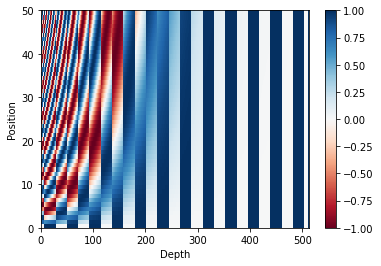

In [14]:
# Positional encoding


def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates



def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis,:]

    return tf.cast(pos_encoding, dtype=tf.float32)



pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## 1. Pad Masking
#### Making all the padded tokens, self attention/attention calculation of a word with those paddings will be ignored


* Here output dimn -> (batch_size, 1, 1, seq_len) 
          
*  for each 8 attention heads, for each query word it will be multiplied, thats why creating 1, 1 in the middle

##### (batch_size, 8, query_word_len, seq_len) * (batch_size, 1, 1, seq_len) 

In [15]:
# Masking

'''Mask all the pad tokens in the batch of sequence. 
It ensures that the model does not treat padding as the input. 
The mask indicates where pad value 0 is present: it outputs a 1 at those locations, and a 0 otherwise.
'''
def create_padding_mask(seq):
    """
    seq: padded sentence length (5)
    """
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    # Adding 2, 3 dimn using tf.newaxis, 2-> As this mask will be multiplied with each attention head and 3-> for each word in a sentance
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)
# create_padding_mask(np.array([[1,2,3,0,0,0],[1,2,3,0,0,1]]))

## 2. Looakahead mask

for the first word, its self attention calculation with be ignored with proceeding words i.e. second, third word and so on

In [16]:
# Looakahead mask

"""The look-ahead mask is used to mask the future tokens in a sequence. 
In other words, the mask indicates which entries should not be used.
"""
def create_look_ahead_mask(size):
    """
    The look-ahead mask is used to mask the future tokens in a sequence
    """
    #band_part with this setting creates lower triangular matrix that's why subtracting from 1
    # [[0., 1., 1.],
    #  [0., 0., 1.],
    #  [0., 0., 0.]] output with size:3
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

#example
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

## 3. SELF-ATTENTION calculation

![image](images/attenion_formula.png)

In [17]:
def scaled_dot_product_attention(q, k, v, mask=None):
    """
    Args:
    q: query shape == (..., seq_len_q, depth) # NOTE: depth=dk
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """ 
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
    # scale matmul_qk. underroot d_model i.e. underroot(100)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    # add the mask to the scaled tensor. 
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  # -1e9 ~ (-INFINITY) => where ever mask is set, make its logit value close to -INF
    # softmax is normalized on the last axis (seq_len_k) so that the scores add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)
    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

## 4. MultiHeadAttention Calculation
#### Its nothing but a RESHAPING !! :)
example : 
1. if we have (64, 10, 512)->(BATCH, #words, embeddding) as input, after passiing it though dense layer of size 512 we will get (64, 10, 512)
2. We have three such dense layers representing/for Q, K, V encodings.
3. (64, 10, 512) -> reshape -> (64, 8, 10 ,64) -> (BATCH, attention head, #words, encode)
    '64' is representing encoding of 512 -> 64 dimension
4. (64, 8, 10 ,64)->self-attention-code->(64, 8, 10 ,10) called attention weights, (64, 8, 10 ,64)
5. Concatenate such that 8*64 will be new dimension -> (64, 10, 512)
    
    **Beware embedding dimn must be divisible by no. of heads and always embedding_dimn/heads => encodin_dimn(here 64)**
    
    **NICE HACK** (-_-)

![image](images/multi_head.png)

In [18]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model  # typically 512

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights
    

## 5. ENCODER layer

#### -> self Multihead attention -> Residual+Norm -> Feed forward neural network -> Residual+Norm

![image](images/encoder_layer.png)


In [19]:
def point_wise_feed_forward_network(d_model, dff): #dff = 512
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])


class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model) # with Attention

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model) #with Attention

        return out2

In [20]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

## 6. DECODER LAYER
#### -> self multihead attention -> residual+norm -> multihead attention(between E & D) -> residual+norm -> feed forward NN -> residual+norm

![image](images/decoder_layer.png)

In [21]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
         
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x) 
        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

## 7. ENCODER 
#### Nothing but repetation of Encoder layer :-) + Input embedding vector + positional encoding

![image](images/encoder.png)

In [22]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.d_model)


        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):

        seq_len = tf.shape(x)[1]   #x:(batch, seq_len)
        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32)) 
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)

## 8. DECODER
#### Nothing but Repetation of decoder layers + posisional encoder + embedding layer

![image](images/decoder.png)

In [23]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

## 9. TRANSFORMER

#### Nothing but encoder+decoder+dense layer
##### (64,10,512) -> dense_layer -> (64,10,vocab_size)

![image](images/transformer.png)


In [24]:

class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                               input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                               target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights

#### So to create a transformer architecture which is now everywhere in NLP models, we require only 9 STEPs :-O

In [25]:
# tokenizer_a = joblib.load("tokenizer_a")
# tokenizer_q = joblib.load("tokenizer_q")

In [26]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_q.vocab_size + 2
target_vocab_size = tokenizer_a.vocab_size + 2
dropout_rate = 0.1

## Custom learning rate, proposed in the paper
#### First learning rate will be high and then after some epochs it will be decreasing ONLY

![image](images/lr.png)


In [27]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [28]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

### See, increasing and then decreasing

Text(0.5, 0, 'Train Step')

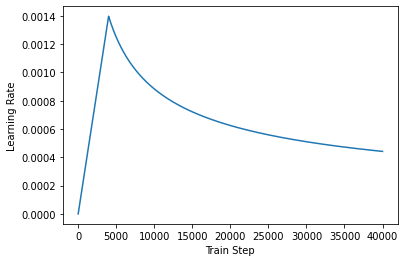

In [29]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

##### Custom losss function, same as sparse categorical cross entropy but considers only no padded values

In [30]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

### Creating pad mask(encoder), pad mask(decoder), lookahead mask(decoder)

In [31]:
def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by 
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

## Saving model checkpoint

In [32]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
input_vocab_size = tokenizer_q.vocab_size + 2
target_vocab_size = tokenizer_a.vocab_size + 2
dropout_rate = 0.1


transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)




checkpoint_path = "./checkpoints_test/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

## Using gradient tape for getting derivatives of loss functions w.r.t. weights then applyiing to optimizer => BACKPROPAGATION

In [33]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp) 
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                     True, 
                                     enc_padding_mask, 
                                     combined_mask, 
                                     dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(tar_real, predictions)

## Creating sample transformer to know the no. of trainable parameters

In [34]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
input_vocab_size = tokenizer_q.vocab_size + 2
target_vocab_size = tokenizer_a.vocab_size + 2
dropout_rate = 0.1

sample_transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

temp_input = tf.random.uniform((64, 27), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 27), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)
sample_transformer.summary()

Model: "transformer_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  3813888   
                                                                 
 decoder_1 (Decoder)         multiple                  4950016   
                                                                 
 dense_135 (Dense)           multiple                  3922116   
                                                                 
Total params: 12,686,020
Trainable params: 12,686,020
Non-trainable params: 0
_________________________________________________________________


In [35]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
input_vocab_size = tokenizer_q.vocab_size + 2
target_vocab_size = tokenizer_a.vocab_size + 2
dropout_rate = 0.1


transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [36]:
EPOCHS = 20
batch_size = 64
metrics_names = ['loss', 'acc'] 
train_loss.reset_states()
train_accuracy.reset_states()
for epoch in range(EPOCHS):
    print("\nepoch {}/{}".format(epoch+1,EPOCHS))
    pb_i = Progbar(train.shape[0], stateful_metrics=metrics_names)
 
    # inp -> question, tar -> answer
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)
        
        values=[('loss',train_loss.result()), ('acc',train_accuracy.result())]
        
        pb_i.add(batch_size, values=values) 
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,ckpt_save_path))


epoch 1/20
111552/111527 [==============================] - 289s 3ms/step - loss: 5.9531 - acc: 0.0851

epoch 2/20
111552/111527 [==============================] - 181s 2ms/step - loss: 5.1311 - acc: 0.1074

epoch 3/20
111552/111527 [==============================] - 184s 2ms/step - loss: 4.7987 - acc: 0.1168

epoch 4/20
111552/111527 [==============================] - 179s 2ms/step - loss: 4.5997 - acc: 0.1227

epoch 5/20
111552/111527 [==============================] - 181s 2ms/step - loss: 4.4632 - acc: 0.1268
Saving checkpoint for epoch 5 at ./checkpoints_test/train/ckpt-1

epoch 6/20
111552/111527 [==============================] - 181s 2ms/step - loss: 4.3647 - acc: 0.1300

epoch 7/20
111552/111527 [==============================] - 181s 2ms/step - loss: 4.2896 - acc: 0.1327

epoch 8/20
111552/111527 [==============================] - 179s 2ms/step - loss: 4.2291 - acc: 0.1350

epoch 9/20
111552/111527 [==============================] - 181s 2ms/step - loss: 4.1786 - acc: 0.1370

In [37]:
EPOCHS = 5
batch_size = 64
metrics_names = ['loss', 'acc'] 
# train_loss.reset_states()
# train_accuracy.reset_states()
for epoch in range(EPOCHS):
    print("\nepoch {}/{}".format(epoch+1,EPOCHS))
    pb_i = Progbar(train.shape[0], stateful_metrics=metrics_names)
 
    # inp -> question, tar -> answer
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)
        
        values=[('loss',train_loss.result()), ('acc',train_accuracy.result())]
        
        pb_i.add(batch_size, values=values) 
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,ckpt_save_path))


epoch 1/5
111552/111527 [==============================] - 181s 2ms/step - loss: 3.8673 - acc: 0.1516

epoch 2/5
111552/111527 [==============================] - 181s 2ms/step - loss: 3.8521 - acc: 0.1524

epoch 3/5
111552/111527 [==============================] - 181s 2ms/step - loss: 3.8376 - acc: 0.1532

epoch 4/5
111552/111527 [==============================] - 181s 2ms/step - loss: 3.8239 - acc: 0.1540

epoch 5/5
111552/111527 [==============================] - 181s 2ms/step - loss: 3.8108 - acc: 0.1547
Saving checkpoint for epoch 5 at ./checkpoints_test/train/ckpt-5


# With those hyperparameters it seems model is not learning at all, as there is no progress in 25 EPOCHS

In [ ]:
MAX_LENGTH = 27 
def evaluate(inp_sentence):
    start_token = [tokenizer_q.vocab_size]
    end_token = [tokenizer_q.vocab_size + 1]

    # inp sentence is portuguese, hence adding the start and end token
    inp_sentence = start_token + tokenizer_q.encode(inp_sentence) + end_token
    encoder_input = tf.expand_dims(inp_sentence, 0)

    # as the target is english, the first word to the transformer should be the
    # english start token.
    decoder_input = [tokenizer_a.vocab_size]
    output = tf.expand_dims(decoder_input, 0)

    for i in range(MAX_LENGTH):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            encoder_input, output)

        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input, 
                                                     output,
                                                     False,
                                                     enc_padding_mask,
                                                     combined_mask,
                                                     dec_padding_mask)

        # select the last word from the seq_len dimension
#         print(predictions.shape,"aa",predictions[: ,-1:, :].shape)
        predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
#         print(predicted_id, output)
    # return the result if the predicted_id is equal to the end token
        if predicted_id == tokenizer_a.vocab_size+1: 
            return tf.squeeze(output, axis=0), attention_weights

    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights

In [39]:
inp_sentence = "i am doing great"
a, b = evaluate(inp_sentence)

# RESULTS are ABSURD

In [40]:
for i in a[1:]:
    print(tokenizer_a.decode([i]))

I 
don
'
t 
know
.


 ## Lets try with different hyperparameters

In [41]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_q.vocab_size + 2
target_vocab_size = tokenizer_a.vocab_size + 2
dropout_rate = 0.1
temp_input = tf.random.uniform((64, 27), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 27), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)
sample_transformer.summary()

Model: "transformer_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  3813888   
                                                                 
 decoder_1 (Decoder)         multiple                  4950016   
                                                                 
 dense_135 (Dense)           multiple                  3922116   
                                                                 
Total params: 12,686,020
Trainable params: 12,686,020
Non-trainable params: 0
_________________________________________________________________


In [42]:
num_layers = 2
d_model = 256
dff = 512
num_heads = 8
input_vocab_size = tokenizer_q.vocab_size + 2
target_vocab_size = tokenizer_a.vocab_size + 2
dropout_rate = 0.1

sample_transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

temp_input = tf.random.uniform((64, 27), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 27), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)
sample_transformer.summary()

Model: "transformer_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_3 (Encoder)         multiple                  7095808   
                                                                 
 decoder_3 (Decoder)         multiple                  9364992   
                                                                 
 dense_233 (Dense)           multiple                  7813828   
                                                                 
Total params: 24,274,628
Trainable params: 24,274,628
Non-trainable params: 0
_________________________________________________________________


### Now the trainable parameters has increased from 12M to 24M, Lets test this!!

In [43]:
EPOCHS = 20
batch_size = 64
metrics_names = ['loss', 'acc'] 
train_loss.reset_states()
train_accuracy.reset_states()
for epoch in range(EPOCHS):
    print("\nepoch {}/{}".format(epoch+1,EPOCHS))
    pb_i = Progbar(train.shape[0], stateful_metrics=metrics_names)
 
    # inp -> question, tar -> answer
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)
        
        values=[('loss',train_loss.result()), ('acc',train_accuracy.result())]
        
        pb_i.add(batch_size, values=values) 
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,ckpt_save_path))


epoch 1/20
111552/111527 [==============================] - 181s 2ms/step - loss: 3.4864 - acc: 0.1732

epoch 2/20
111552/111527 [==============================] - 181s 2ms/step - loss: 3.4799 - acc: 0.1735

epoch 3/20
111552/111527 [==============================] - 182s 2ms/step - loss: 3.4746 - acc: 0.1738

epoch 4/20
111552/111527 [==============================] - 181s 2ms/step - loss: 3.4696 - acc: 0.1741

epoch 5/20
111552/111527 [==============================] - 181s 2ms/step - loss: 3.4644 - acc: 0.1745
Saving checkpoint for epoch 5 at ./checkpoints_test/train/ckpt-6

epoch 6/20
111552/111527 [==============================] - 181s 2ms/step - loss: 3.4594 - acc: 0.1748

epoch 7/20
111552/111527 [==============================] - 182s 2ms/step - loss: 3.4546 - acc: 0.1751

epoch 8/20
111552/111527 [==============================] - 181s 2ms/step - loss: 3.4500 - acc: 0.1754

epoch 9/20
111552/111527 [==============================] - 181s 2ms/step - loss: 3.4451 - acc: 0.1757

In [ ]:
EPOCHS = 30
batch_size = 64
metrics_names = ['loss', 'acc'] 
# train_loss.reset_states()
# train_accuracy.reset_states()
for epoch in range(EPOCHS):
    print("\nepoch {}/{}".format(epoch+1,EPOCHS))
    pb_i = Progbar(train.shape[0], stateful_metrics=metrics_names)
 
    # inp -> question, tar -> answer
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)
        
        values=[('loss',train_loss.result()), ('acc',train_accuracy.result())]
        
        pb_i.add(batch_size, values=values) 
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,ckpt_save_path))

## Learning is slow, but not stagnant (-__-)

In [ ]:
EPOCHS = 100
batch_size = 64
metrics_names = ['loss', 'acc'] 
# train_loss.reset_states()
# train_accuracy.reset_states()
for epoch in range(50, EPOCHS):
    print("\nepoch {}/{}".format(epoch+1,EPOCHS))
    pb_i = Progbar(train.shape[0], stateful_metrics=metrics_names)
 
    # inp -> question, tar -> answer
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)
        
        values=[('loss',train_loss.result()), ('acc',train_accuracy.result())]
        
        pb_i.add(batch_size, values=values) 
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,ckpt_save_path))

In [ ]:
EPOCHS = 150
batch_size = 64
metrics_names = ['loss', 'acc'] 
# train_loss.reset_states()
# train_accuracy.reset_states()
for epoch in range(100, EPOCHS):
    print("\nepoch {}/{}".format(epoch+1,EPOCHS))
    pb_i = Progbar(train.shape[0], stateful_metrics=metrics_names)
 
    # inp -> question, tar -> answer
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)
        
        values=[('loss',train_loss.result()), ('acc',train_accuracy.result())]
        
        pb_i.add(batch_size, values=values) 
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,ckpt_save_path))

In [ ]:
EPOCHS = 200
batch_size = 64
metrics_names = ['loss', 'acc'] 
# train_loss.reset_states()
# train_accuracy.reset_states()
for epoch in range(150, EPOCHS):
    print("\nepoch {}/{}".format(epoch+1,EPOCHS))
    pb_i = Progbar(train.shape[0], stateful_metrics=metrics_names)
 
    # inp -> question, tar -> answer
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)
        
        values=[('loss',train_loss.result()), ('acc',train_accuracy.result())]
        
        pb_i.add(batch_size, values=values) 
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,ckpt_save_path))

In [ ]:
EPOCHS = 300
batch_size = 64
metrics_names = ['loss', 'acc'] 
# train_loss.reset_states()
# train_accuracy.reset_states()
for epoch in range(200, EPOCHS):
    print("\nepoch {}/{}".format(epoch+1,EPOCHS))
    pb_i = Progbar(train.shape[0], stateful_metrics=metrics_names)
 
    # inp -> question, tar -> answer
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)
        
        values=[('loss',train_loss.result()), ('acc',train_accuracy.result())]
        
        pb_i.add(batch_size, values=values) 
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,ckpt_save_path))

In [ ]:
EPOCHS = 350
batch_size = 64
metrics_names = ['loss', 'acc'] 
# train_loss.reset_states()
# train_accuracy.reset_states()
for epoch in range(300, EPOCHS):
    print("\nepoch {}/{}".format(epoch+1,EPOCHS))
    pb_i = Progbar(train.shape[0], stateful_metrics=metrics_names)
 
    # inp -> question, tar -> answer
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)
        
        values=[('loss',train_loss.result()), ('acc',train_accuracy.result())]
        
        pb_i.add(batch_size, values=values) 
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,ckpt_save_path))

# EPOCH:350, I think its enough, let's check what type of REPLIES that CHATBOT is generating

In [ ]:
# joblib.dump(tokenizer_q, "tokenizer_q")
# joblib.dump(tokenizer_a, "tokenizer_a")
# transformer.save_weights('transformer_model/weights')

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    
    fontdict = {'fontsize': 14}
    sentence = sentence.split(" ")
    predicted_sentence = predicted_sentence.split(" ")
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)



def plot_attention_weights(attention,tokenizer_q, tokenizer_a, sentence, result, layer):
    
    fig = plt.figure(figsize=(16, 8))

    sentence = tokenizer_q.encode(sentence)

    attention = tf.squeeze(attention[layer], axis=0)
    #(1, 8, 5, 4) --> (8, 5, 4)
    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head+1)

        # plot the attention weights [:-1, :]
        ax.matshow(attention[head][:-1, :], cmap='viridis')
        fontdict = {'fontsize': 10}
        
        ax.set_xticks(range(len(sentence)+2))
        ax.set_yticks(range(len(result)-1))

        ax.set_ylim(len(result)-1.5, -0.5)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
        x = ['<start>']+[tokenizer_q.decode([i]) for i in sentence]+['<end>']
        y = [tokenizer_a.decode([i]) for i in result if i < tokenizer_a.vocab_size]
        ax.set_xticklabels([''] + x, fontdict=fontdict, rotation=90)
        ax.set_yticklabels([''] + y, fontdict=fontdict)


        ax.set_xlabel('Head {}'.format(head+1))
  
    plt.tight_layout()
    plt.show()
    
    
MAX_LENGTH = 27 

def evaluate(inp_sentence, model,  tokenizer_q, tokenizer_a):
    start_token = [tokenizer_q.vocab_size]
    end_token = [tokenizer_q.vocab_size + 1]

    # All questions has the start and end token
    inp_sentence = start_token + tokenizer_q.encode(inp_sentence) + end_token
    encoder_input = tf.expand_dims(inp_sentence, 0)

    # 'answers' start token : 27358
    decoder_input = [tokenizer_a.vocab_size]
    decoder_input = tf.expand_dims(decoder_input, 0)

    for i in range(MAX_LENGTH):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, decoder_input)

        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = model(encoder_input, 
                                                     decoder_input,
                                                     False,
                                                     enc_padding_mask,
                                                     combined_mask,
                                                     dec_padding_mask)

        # select the last word from the seq_len dimension
        predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # return the result if the predicted_id is equal to the end token
        if predicted_id == tokenizer_a.vocab_size+1:
            print(f"=============\nGot end token\n=============")
            return tf.squeeze(decoder_input, axis=0), attention_weights

        # concatentate the predicted_id to the output which is given to the decoder
        # as its input.
        decoder_input = tf.concat([decoder_input, predicted_id], axis=-1)

    return tf.squeeze(decoder_input, axis=0), attention_weights

In [ ]:
def reply(sentence, transformer,  tokenizer_q, tokenizer_a, plot=''):
    result, attention_weights = evaluate(sentence, transformer,  tokenizer_q, tokenizer_a)
#     print("Attention_Blocks:", list(attention_weights.keys()))
    predicted_sentence = tokenizer_a.decode([i for i in result 
                                            if i < tokenizer_a.vocab_size])  
  
    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(predicted_sentence))
    if plot:
        plot_attention_weights(attention_weights,tokenizer_q, tokenizer_a, sentence, result, plot)
    return sentence, predicted_sentence

In [ ]:
inp_sentence = "i was told ten thousand in each pack"
reply(inp_sentence, transformer,  tokenizer_q, tokenizer_a, "decoder_layer2_block2")

## OUTPUTS are not absurd at all, It has LEARNED

In [ ]:
inp_sentence = "i did not sleep well"
reply(inp_sentence, transformer,  tokenizer_q, tokenizer_a)

In [ ]:
train.iloc[400:406]

In [ ]:
validation.iloc[400:406]

In [ ]:
import nltk.translate.bleu_score as bleu
from tqdm import tqdm
test_q = train["question"].values[:10]
test_a = train["answer"].values[:10]
bss = []
for i in range(10):
    input_test_sentence = test_q[i]
    input_sentence, pred_string = reply(input_test_sentence, transformer,  tokenizer_q, tokenizer_a, plot='')
    print("Actual:", test_a[i])
    reference = [test_a[i].split()] # the original
    translation = pred_string.split() # trasilated using model
#     bs = bleu.sentence_bleu(reference, translation)
#     bss.append(bs)


In [ ]:
import nltk.translate.bleu_score as bleu
from tqdm import tqdm
test_q = validation["question"].values[100:110]
test_a = validation["answer"].values[100:110]
bss = []
for i in range(10):
    input_test_sentence = test_q[i]
    input_sentence, pred_string = reply(input_test_sentence, load_transformer,  tokenizer_q, tokenizer_a, plot='')
    print("Actual:", test_a[i])
    reference = [test_a[i].split()] # the original
    translation = pred_string.split() # trasilated using model

In [ ]:
# num_layers = 2
# d_model = 256
# dff = 512
# num_heads = 8
# input_vocab_size = tokenizer_q.vocab_size + 2
# target_vocab_size = tokenizer_a.vocab_size + 2
# dropout_rate = 0.1

# load_transformer = Transformer(num_layers, d_model, num_heads, dff,
#                           input_vocab_size, target_vocab_size, 
#                           pe_input=input_vocab_size, 
#                           pe_target=target_vocab_size,
#                           rate=dropout_rate)
# load_transformer.load_weights('transformer_model/weights')

In [ ]:
inp_sentence = "i was told ten thousand in each pack"
reply(inp_sentence, load_transformer,  tokenizer_q, tokenizer_a, "decoder_layer2_block2")

* Results are great, better than encoder-decoder with bahadenau attention mechanism
* Still we can see the results are not perfect, because the architecture has less parameters plus the dataset is not very big and transformers works close to humans with large data and large trainable parameters

# On random inputs!
### Results are genuine

In [ ]:
inp_sentence = "hi"
reply(inp_sentence, load_transformer,  tokenizer_q, tokenizer_a)


In [ ]:
inp_sentence = "Where have you been"
reply(inp_sentence, load_transformer,  tokenizer_q, tokenizer_a)


#### Making sense haha : ) "who are you"

In [ ]:
inp_sentence = "who are you"
reply(inp_sentence, load_transformer,  tokenizer_q, tokenizer_a)


####  Again making sense "where do you live"

In [ ]:
inp_sentence = "where do you live"
reply(inp_sentence, load_transformer,  tokenizer_q, tokenizer_a)

In [ ]:
inp_sentence = "what is your name"
reply(inp_sentence, load_transformer,  tokenizer_q, tokenizer_a)

In [ ]:
inp_sentence = "why are you angry with me is there anything i did wrong"
reply(inp_sentence, load_transformer,  tokenizer_q, tokenizer_a)

# Even with this small architecture its working fine, what else it could do If I train it with trainable parameters with more data